## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [546]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os
import matplotlib.pyplot as plt

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [481]:
## your code here
debar = pd.read_csv("debar.csv")
debar.head()


,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [484]:
## your code here

debar_rows = len(debar)
print(debar_rows)

debar_unique = debar.Name.nunique()
print(debar_unique)

employer_values = debar.Name.value_counts()
print(employer_values)

114
98
Name
Dove Creek Farms                                                  2
Turner Farms                                                      2
Xavier Horne                                                      2
Macky and Brad Farms                                              2
Old Tree Farms/Verpaalen Custom Service                           2
                                                                 ..
Walker Place                                                      1
County Fair Farm (company) and Andrew Williamson (individual)*    1
Jesus Ledesma                                                     1
B & R Harvesting and Paul Cruz (individual)                       1
First American Holdings                                           1
Name: count, Length: 98, dtype: int64


Since there are more rows than unique employer names and certain employers have values of greater than 1, there are multiple rows for some employers.

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [488]:
## your code here
# part A
debar['is_repeated'] = debar['Name'].isin(employer_values[employer_values > 1].index)
print(debar[['Name', 'is_repeated']])

# part B
print(debar[debar['is_repeated'] == True])

# part C
mult_debar = debar[debar['is_repeated'] == True]
print(mult_debar.head())
print(mult_debar.shape)

                                            Name  is_repeated
0                                 J&J Harvesting        False
1                         Stahlman Apiaries, Inc        False
2                                  Trust Nursery        False
3                          Anton Fertilizer Inc.        False
4               Great Plains Fluid Service, Inc.        False
..                                           ...          ...
109                             Dove Creek Farms         True
110                                Jesus Ledesma        False
111                                 Turner Farms         True
112  B & R Harvesting and Paul Cruz (individual)        False
113                                  Delia Rojas        False

[114 rows x 2 columns]
                                        Name       City, State  \
6                    Annabella Land & Cattle     Annabella, UT   
7                        Autumn Hill Orchard        Groton, MA   
8      Caddo Creek Ranch, dba Para

The rows of this dataset for which 'is_repeated' is True tend to be orchards or farms, indicating repeat offenses of unlawful employment primarily for food businesses. This fits with migrant worker trends in the US.

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [492]:
## your code here
# print(mult_debar.columns)

full_states = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT',
                       'Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA',
                       'Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
                       'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ',
                       'New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
                       'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT',
                       'Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

# from office hours help
def states(name):
    string = name.split(", ")
    if string[1] in full_states:
        abrev = full_states[string[1]]
        return string[0] + ", " + abrev
    else:
        return name


In [494]:
## From office hours help
wrong_states_dict = {"Brownfield, TX" : "Brownsville, TX",
                     "Altheimer, AK" : "Altheimer, AR"}

def wrong_cities(name):
    if name in wrong_states_dict:
        return wrong_states_dict[name]
    else:
        return name


In [496]:
mult_debar["City, State"] = mult_debar["City, State"].apply(states)
mult_debar["City, State"] = mult_debar["City, State"].apply(wrong_cities)

/var/folders/tj/gn0fs7tx6ml_jnjbzkw10wpr0000gn/T/ipykernel_60758/3636892746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar["City, State"] = mult_debar["City, State"].apply(states)
/var/folders/tj/gn0fs7tx6ml_jnjbzkw10wpr0000gn/T/ipykernel_60758/3636892746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar["City, State"] = mult_debar["City, State"].apply(wrong_cities)


In [498]:
mult_debar

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True
14,Sharon Mathis,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
15,SRT Farms,"Morton, TX",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
16,Mark Duncan,"Roosevelt, UT",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
17,"Maple Ridge Custom Services, LLC","Altheimer, AR",Failure to respond to audit (partial response),2 years,11/16/2014,11/15/2016,True
18,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,True


In [500]:
mult_debar['violation'] = mult_debar.groupby(['Name', 'City, State'])['Start date'].transform(lambda x: range(1, len(x) + 1))
mult_debar_wide = mult_debar.pivot(index = ["Name", "City, State"], columns = "violation", values = "Start date").reset_index()
mult_debar_wide.columns = ["Name", "City, State", "start_date_viol1", "start_date_viol2"]

# print
mult_debar_wide.head()
mult_debar_wide.shape

/var/folders/tj/gn0fs7tx6ml_jnjbzkw10wpr0000gn/T/ipykernel_60758/455118438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar['violation'] = mult_debar.groupby(['Name', 'City, State'])['Start date'].transform(lambda x: range(1, len(x) + 1))


,Name,"City, State",start_date_viol1,start_date_viol2
0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
1,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
3,Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
4,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018


(16, 4)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [566]:
## your code here
# part A
mult_debar_wide['is_dup'] = np.where(mult_debar_wide['start_date_viol1'] == mult_debar_wide['start_date_viol2'], True, False)
print(mult_debar_wide.is_dup)

# part B
mult_debar_wide.reset_index()

mult_debar_wide.columns
repeats = mult_debar_wide[mult_debar_wide['is_dup'] == True].index.get_level_values(0).unique().tolist()
debar['is_dup'] = debar['Name'].isin(repeats)

# from oh
debar_clean = debar.drop_duplicates(keep="first", subset=["Name","Start date", "is_dup"])
debar_clean = debar_clean.drop(columns=['is_repeated'])


debar_clean.shape 
debar_clean['Name'].nunique() 

0      True
1      True
2      True
3     False
4      True
5      True
6      True
7      True
8      True
9      True
10    False
11     True
12     True
13     True
14     True
15    False
Name: is_dup, dtype: bool


,index,Name,"City, State",start_date_viol1,start_date_viol2,is_dup
0,0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014,True
1,1,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014,True
2,2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014,True
3,3,Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015,False
4,4,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018,True
5,5,F&W Farms,"Ingalls, KS",12/10/2014,12/10/2014,True
6,6,Loewen Harvesting LLC,"Brownsville, TX",8/20/2014,8/20/2014,True
7,7,Macky and Brad Farms,"Plains, TX",2/13/2015,2/13/2015,True
8,8,"Maple Ridge Custom Services, LLC","Altheimer, AR",11/16/2014,11/16/2014,True
9,9,Mark Duncan,"Roosevelt, UT",11/16/2014,11/16/2014,True


Index(['Name', 'City, State', 'start_date_viol1', 'start_date_viol2',
       'is_dup'],
      dtype='object')

(101, 9)

98

# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset2_inputdata`

In [512]:
# your code here to load the data 
jobs = pd.read_csv("jobs.csv")
jobs.head()


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4


##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [515]:
## your code here
# Part A
new_debar = pd.merge(jobs, debar_clean, left_on = "EMPLOYER_NAME", right_on = "Name", how = "inner")
# Part B
print(new_debar)

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20287-876656  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-10-20 09:20:32.010  2020-11-09 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    Y                 Seasonal   

  EMERGENCY_FILING   EMPLOYER_NAME TRADE_NAME_DBA  ... EMAIL_TO_APPLY  \
0                Y  Rafael Barajas            NaN  ...            NaN   

                WEBSITE_TO_APPLY TOTAL_ADDENDUM_A_RECORDS            Name  \
0  https://seasonaljobs.dol.gov/                        7  Rafael Barajas   

        City, State                         Violation Duration  Start date  \
0  Sebring, Florida  Non-payment of certification fee   1 year   9/23/2016   

    End date  is_dup  
0  9/22/2017   False  

[1 rows x 145 columns]


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [519]:
## insert your code to turn into uppercase here Part A and C
jobs.EMPLOYER_NAME = [case.upper() for case in jobs.EMPLOYER_NAME]
debar_clean.Name = [case.upper() for case in debar_clean.Name]

In [525]:
## insert your code for the random sample
jobs_random = np.random.choice(jobs.EMPLOYER_NAME, size = 15)
jobs_random
debar_random = np.random.choice(debar_clean.Name, size = 15)
debar_random

array(['BLACK BEAR ORCHARDS, LLC', 'DARREL DIRKS FARMS ', 'TNT LIVESTOCK',
       'STRIPPIN FEATHERS, LLC', 'KYLE LEJEUNE',
       'FARM LABOR ASSOCIATION FOR GROWERS, INC.',
       'WESTERN RANGE ASSOCIATION',
       "ABENDROTH'S APPLE RIDGE ORCHARDS LLC",
       'DEL NORTE HARVESTING, LLC', 'FARMERS ORGANICS', 'BENWOOD FARMS',
       'WATKINS FAMILY PARTNERSHIP', 'WONDERFUL BEES',
       'WOLF ONE FARMS, INC.', 'JOHN IHRY'], dtype=object)

array(['ROSALVA GARCIA', 'TRUST NURSERY', 'XAVIER HORNE', 'DELIA ROJAS',
       'XAVIER HORNE', 'DELIA ROJAS', 'VALLEY VIEW ORCHARDS',
       'LOV RANCH CO, LLLP DBA LOV RANCH', 'GLENDA HARROD FARMS',
       'JIM AND ANN SHIPLEY WILLIAM SHIPLEY*', 'SRT FARMS', 'DANECO, LLC',
       'CISCO PRODUCE INC.', 'ROBERT D. TOWLES',
       'OLD TREE FARMS/VERPAALEN CUSTOM SERVICE'], dtype=object)

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [528]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [530]:
## insert your code here with the regex pattern for part A
def chopped_employers(input):
    name_chop = re.sub(r'\b(INC|LLC|CO)\.', r'\1', input)
    return name_chop

## insert your code to use re.sub to apply the pattern to the test cases for part B
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

chopped_employers(pos_example_1)
chopped_employers(pos_example_2)
chopped_employers(neg_example)

'CISCO PRODUCE INC'

'AVOYELLES HONEY CO, LLC'

'E.V. RANCH LLP'

### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [533]:
## your code here to clean the columns

# jobs
jobs['name_clean'] = [chopped_employers(name) for name in jobs['EMPLOYER_NAME']]
changed_jobs = jobs[jobs['EMPLOYER_NAME'] != jobs['name_clean']]
print(changed_jobs[['EMPLOYER_NAME', 'name_clean']])


# debar clean
debar_clean['name_clean'] = [chopped_employers(name) for name in debar_clean['Name']]
changed_debar = debar_clean[debar_clean['Name'] != debar_clean['name_clean']]
print(changed_debar[['Name', 'name_clean']])


                                 EMPLOYER_NAME  \
4                      DUNSON HARVESTING, INC.   
7     FARM LABOR ASSOCIATION FOR GROWERS, INC.   
14                          MCLAIN FARMS, INC.   
17                         BONNIE PLANTS, INC.   
18                 B & W QUALITY GROWERS, INC.   
...                                        ...   
2700                  HARRAL LIVESTOCK CO. LLC   
2701                   ECOSYSTEM CONCEPTS INC.   
2702                        SIDDOWAY SHEEP CO.   
2705                    SATHER MANAGEMENT INC.   
2711                   C R KOEHL AND SONS INC.   

                                   name_clean  
4                      DUNSON HARVESTING, INC  
7     FARM LABOR ASSOCIATION FOR GROWERS, INC  
14                          MCLAIN FARMS, INC  
17                         BONNIE PLANTS, INC  
18                 B & W QUALITY GROWERS, INC  
...                                       ...  
2700                  HARRAL LIVESTOCK CO LLC  
2701           

In [535]:
## your code here to print the head
jobs.head()
debar_clean.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,name_clean
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"FAZIO FARMS OPERATING COMPANY, LLC",NaN,...,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0,"FAZIO FARMS OPERATING COMPANY, LLC"
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,CHARLIE SUNDERLAND,Panter & Sunderland Nursery,...,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0,CHARLIE SUNDERLAND
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,MICHAEL RUDEBUSCH,NaN,...,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0,MICHAEL RUDEBUSCH
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,LODAHL FARMS,NaN,...,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0,LODAHL FARMS
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"DUNSON HARVESTING, INC.","Dunson Harvesting, Inc.",...,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4,"DUNSON HARVESTING, INC"


,Name,"City, State",Violation,Duration,Start date,End date,is_dup,name_clean
0,J&J HARVESTING,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016,False,J&J HARVESTING
1,"STAHLMAN APIARIES, INC","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016,False,"STAHLMAN APIARIES, INC"
2,TRUST NURSERY,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015,False,TRUST NURSERY
3,ANTON FERTILIZER INC.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,False,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,False,"GREAT PLAINS FLUID SERVICE, INC"


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [542]:
## your code here
# Part A
employer_inner = pd.merge(jobs, debar_clean, left_on = "name_clean", right_on = "name_clean", how = "inner")
print(employer_inner)

# Part B
def cleaned_ev(input):
    new_phrase = re.sub(r'E\.V\.', 'EV', input) 
    new_phrase = re.sub(r'\s*LLP\.?\s*', '', new_phrase) 
    return new_phrase

debar_clean['name_clean_2'] = [cleaned_ev(name) for name in debar_clean['name_clean']]

# Part C 
employer_left = pd.merge(jobs, debar_clean, left_on = "name_clean", right_on = "name_clean_2", how = "left", indicator = True)

both_frames = employer_left[employer_left['_merge'] == 'both']
both_frames

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20287-876656  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-10-20 09:20:32.010  2020-11-09 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    Y                 Seasonal   

  EMERGENCY_FILING   EMPLOYER_NAME TRADE_NAME_DBA  ...  \
0                Y  RAFAEL BARAJAS            NaN  ...   

  TOTAL_ADDENDUM_A_RECORDS      name_clean            Name       City, State  \
0                        7  RAFAEL BARAJAS  RAFAEL BARAJAS  Sebring, Florida   

                          Violation Duration Start date   End date  is_dup  \
0  Non-payment of certification fee   1 year  9/23/2016  9/22/2017   False   

     name_clean_2  
0  RAFAEL BARAJAS  

[1 rows x 147 columns]


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,Name,"City, State",Violation,Duration,Start date,End date,is_dup,name_clean_y,name_clean_2,_merge
791,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,False,RAFAEL BARAJAS,RAFAEL BARAJAS,both
1115,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,False,SLASH E.V. RANCH LLP,SLASH EV RANCH,both


The part A cleaning resulted in one match: Rafael Barajas.

# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Number of Violations Over Time Per Month')

Text(0.5, 0, 'Month/Year')

Text(0, 0.5, 'Number of Violations')

(array([15706., 16071., 16436., 16801., 17167., 17532., 17897., 18262.]),
 [Text(15706.0, 0, '2013'),
  Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020')])

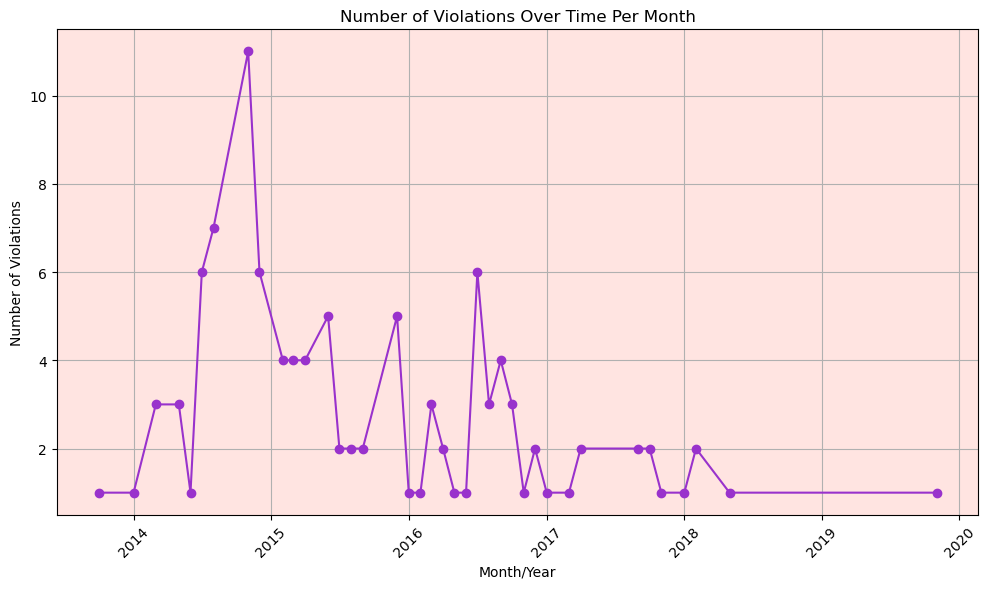

In [564]:
# 1 pt extra
## your code here
debar['Start date'] = pd.to_datetime(debar['Start date'], errors='coerce')
debar['Month/Year'] = debar['Start date'].dt.to_period('M')
viol_by_month = debar.groupby('Month/Year').size().reset_index(name='Number of Violations')
viol_by_month['Month/Year'] = viol_by_month['Month/Year'].dt.to_timestamp()

plt.figure(figsize=(10, 6))
plt.plot(viol_by_month['Month/Year'], viol_by_month['Number of Violations'], marker='o', linestyle='-', color='darkorchid')
plt.title('Number of Violations Over Time Per Month')
plt.xlabel('Month/Year')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45)
plt.grid()
plt.gca().set_facecolor('mistyrose')

plt.tight_layout()
plt.show()